In [1]:
from IPython.core.interactiveshell import InteractiveShell
from datetime import datetime
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import seaborn as sns
sns.set()
import scipy.stats as st
from scipy.stats import norm
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
InteractiveShell.ast_node_interactivity = "all"

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

## Data Uploading

In [2]:
df_train = pd.read_csv('train.csv', index_col='Month')
df_train.tail()

,Sunspots
Month,
1939-09,112.6
1939-10,88.1
1939-11,68.1
1939-12,42.1
1940-01,50.5


In [3]:
df_train.shape

(2293, 1)

In [4]:
df_test = pd.read_csv('test.csv', index_col='Month')
df_test

,Sunspots
Month,
1940-01,0
1940-02,0
1940-03,0
1940-04,0
1940-05,0
...,...
1983-08,0
1983-09,0
1983-10,0


## Moving Average

In [5]:
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
def rmse(y_predicted, y_actual):
        return np.sqrt(mean_squared_error(y_actual, y_predicted))
    
rmse_score = make_scorer(rmse, greater_is_better=False)

In [7]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(df_train, 12) # prediction for the last observed n

86.26666666666667

In [8]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

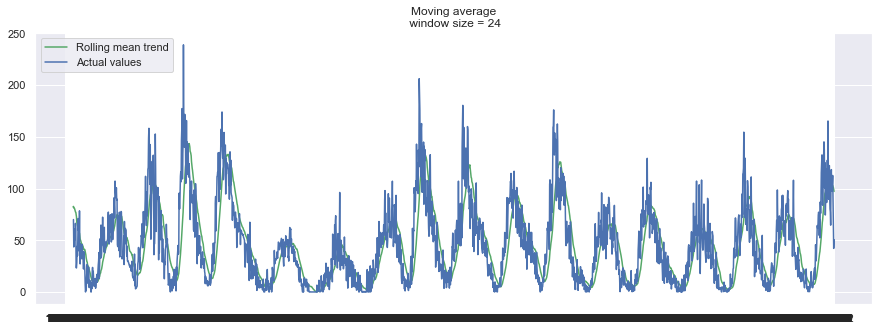

In [33]:
plotMovingAverage(df_train, 24, plot_intervals=False)

In [34]:
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

weighted_average(df_train.Sunspots, [0.6, 0.2, 0.1, 0.07, 0.03])

96.452

## Holt-Winters

In [9]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [93]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you
slen = 124
def timeseriesCVscore(params, series, loss_function=rmse, slen=slen):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=5) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [94]:
data = df_train.Sunspots # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, ), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 528, scaling_factor = 2)

model.triple_exponential_smoothing()

0.003332793229662845 0.0018762337074013646 0.02782304510705358


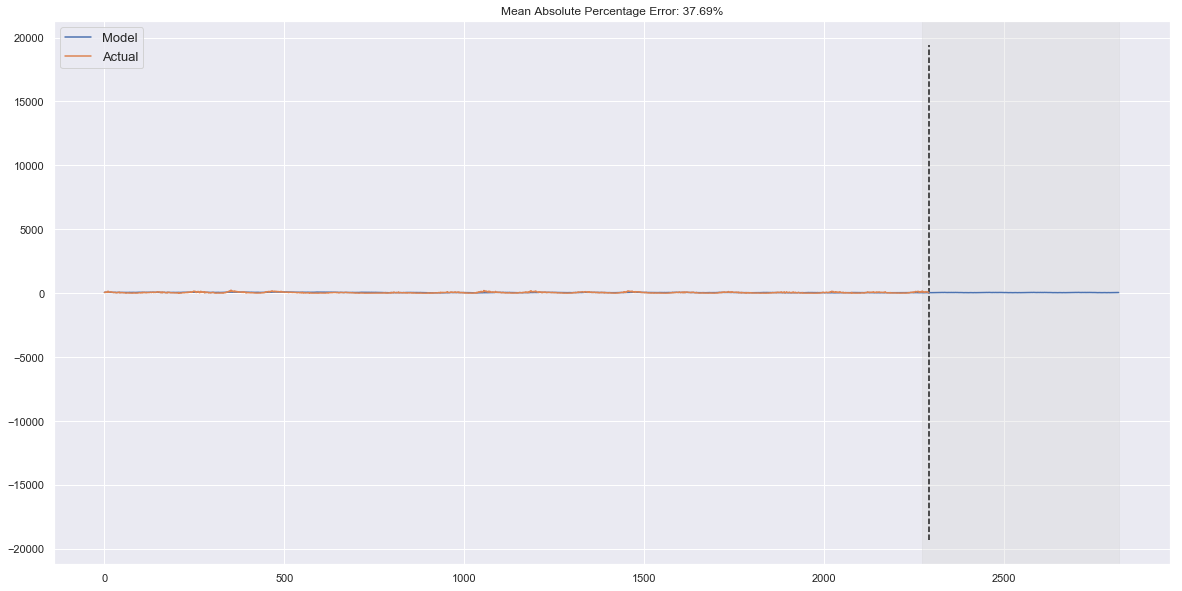

In [95]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = rmse(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);
    
plotHoltWinters(data)

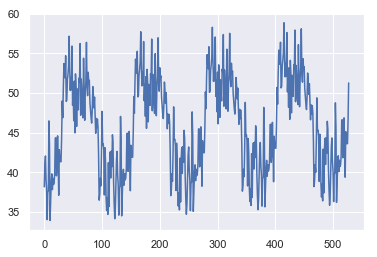

In [96]:
plt.plot(np.array(model.result[-528:]))
pred_hltw = np.array(model.result[-528:])

## Modeling

In [87]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

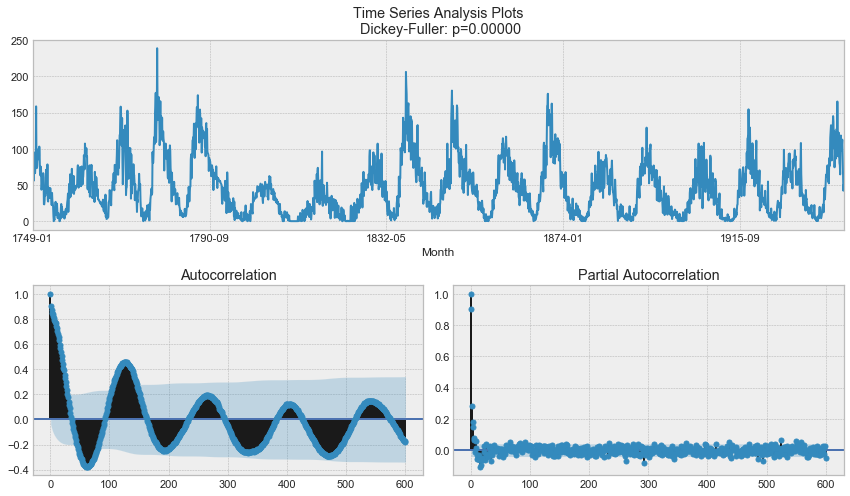

In [88]:
tsplot(df_train.Sunspots, lags=600)

Оптимальный параметр преобразования Бокса-Кокса: 0.381345


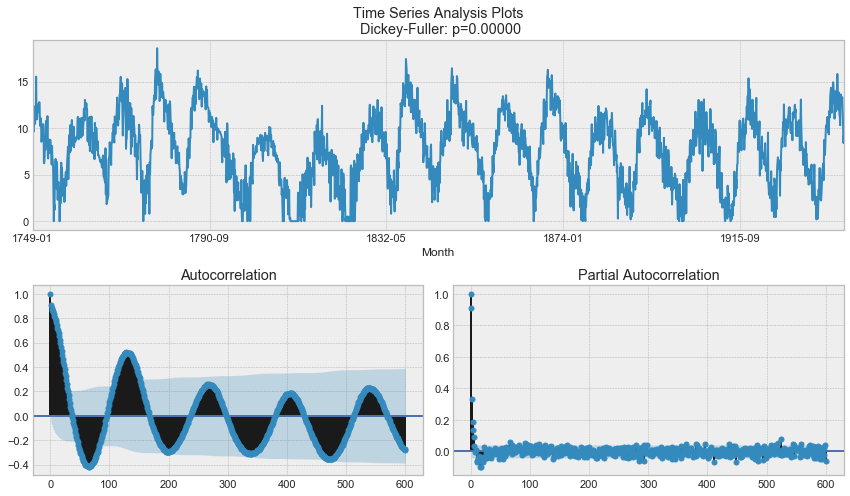

In [344]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

df_train['box'], lmbda = scs.boxcox(df_train.Sunspots+1) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(df_train.box, lags=600)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

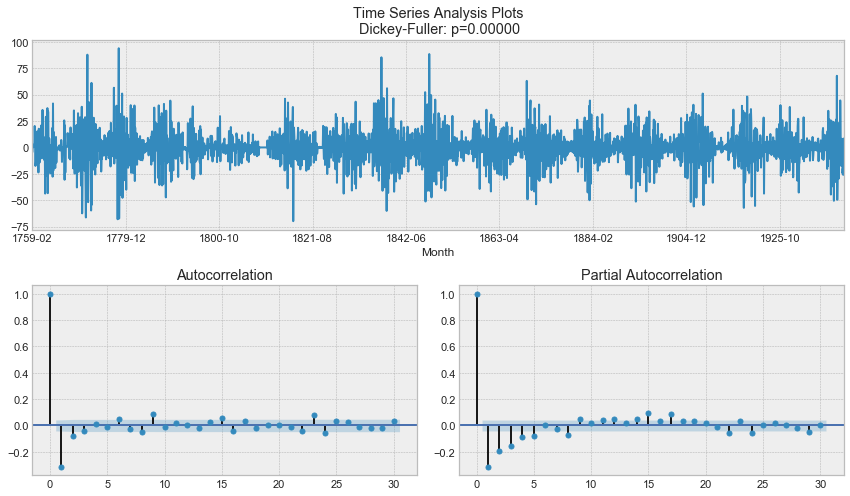

In [89]:
df_train['box_diff'] = df_train.Sunspots - df_train.Sunspots.shift(1)
tsplot(df_train['box_diff'][120+1:], lags=30)

### SARIMA

In [146]:
p = 4
d = 1
q = 4

P = 2
D = 1
Q = 1
s = 25

In [90]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 120 # season length

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [91]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(endog=df_train.box_diff, order=(param[0], d, param[1]), 
                                         seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
result_table = optimizeSARIMA(parameters_list, d, D, s)

In [399]:
best_model

In [442]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df_train.box_diff, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())
#SARIMAX(4, 1, 4)x(0, 1, 1, 24) 

                                 Statespace Model Results                                 
Dep. Variable:                                box   No. Observations:                 2293
Model:             SARIMAX(3, 1, 2)x(0, 1, 1, 12)   Log Likelihood               -4092.584
Date:                            Mon, 11 Nov 2019   AIC                           8199.168
Time:                                    05:19:58   BIC                           8239.291
Sample:                                01-01-1749   HQIC                          8213.803
                                     - 01-01-1940                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2708      0.030     41.735      0.000       1.211       1.331
ar.L2         -0.2529      0.032   

In [ ]:
tsplot(best_model.resid[120+1:], lags=1000)

In [422]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

In [425]:
plotSARIMA(df_train, best_model, 50)

ValueError: Length mismatch: Expected axis has 4 elements, new values have 1 elements

<Figure size 1080x504 with 0 Axes>

Text(0.5, 1.0, 'SARIMA model\n Mean absolute error 11.0')

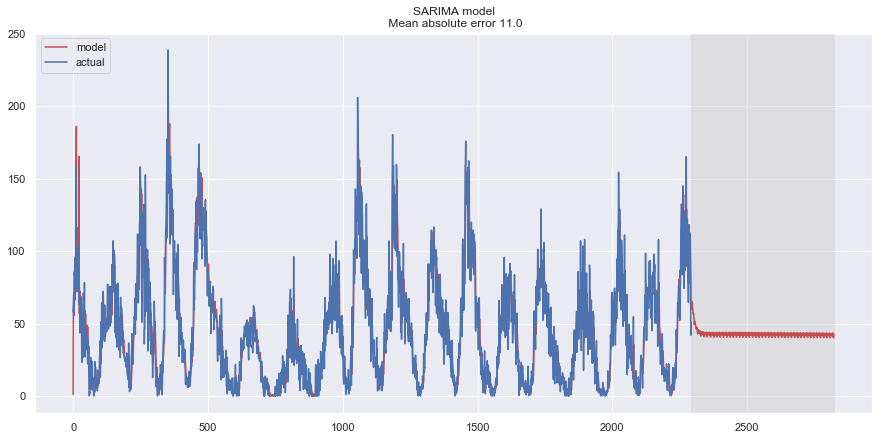

In [450]:
df_train['arima_model'] = invboxcox(best_model.fittedvalues, lmbda) # обратное преобразование Бокса-Кокса
forecast = invboxcox(best_model.predict(start = df_train.shape[0], end = df_train.shape[0]+528), lmbda)
forecast = df_train.arima_model.append(forecast).values
actual = df_train.Sunspots.values
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {}".format(
    round(mean_absolute_error(df_train.dropna().Sunspots, df_train.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

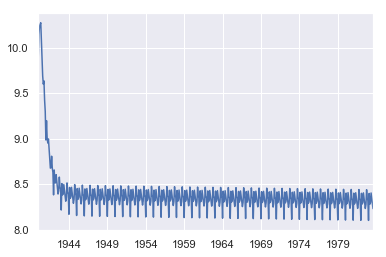

In [451]:
best_model.get_prediction(start = '1940-01', end = '1983-08', exog=df_train.box).predicted_mean.loc['1940-01':].plot()

## Submission

In [97]:
pred_final = pd.DataFrame(
    zip(df_test.index, pred_hltw[-528:]), 
    columns = ['Month', 'Sunspots'])

,Month,Sunspots
0,1940-01,50.500000
1,1940-02,40.995526
2,1940-03,42.055360
3,1940-04,39.089416
4,1940-05,37.871660
...,...,...
523,1983-08,43.888718
524,1983-09,43.600502
525,1983-10,43.611299
526,1983-11,46.621354


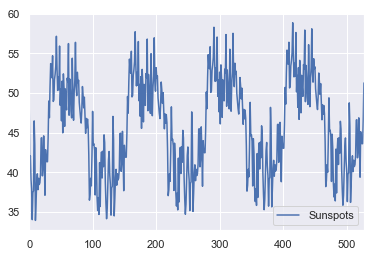

In [98]:
pred_final.iloc[0,1] = 50.5
pred_final.plot()
pred_final

In [99]:
pred_final.to_csv('pred_hw12.csv', index=False)

## Averaging

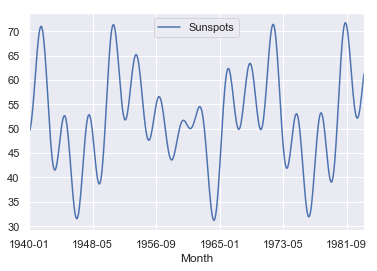

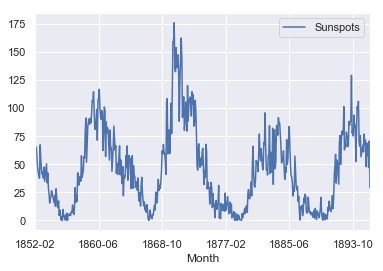

In [26]:
pred_fb = pd.read_csv('pred_hw12-16-2.csv', index_col='Month')
pred_fb.plot()
df_train[-1056:-528].plot()

,Sunspots
Month,
1940-01,50.500000
1940-02,49.682933
1940-03,50.175728
1940-04,50.919207
1940-05,51.899817
...,...
1983-08,56.431577
1983-09,57.612947
1983-10,58.833649


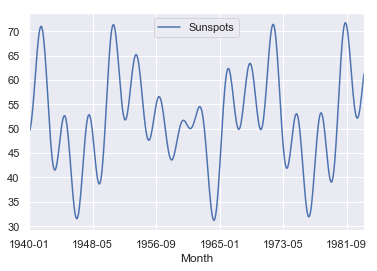

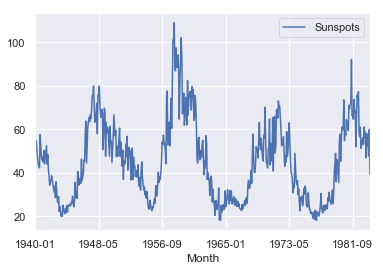

In [104]:
pred_avg = pred_fb.copy()
pred_avg['Sunspots'] = pred_fb.values*0.25+df_train[-1056:-528].values*0.5+pred_hltw*0.25
pred_fb.plot()
pred_avg.plot()
pred_fb

In [105]:
pred_avg.iloc[0] = 50.5
pred_avg

,Sunspots
Month,
1940-01,50.500000
1940-02,52.559726
1940-03,54.782924
1940-04,49.718794
1940-05,45.963947
...,...
1983-08,52.496886
1983-09,57.892229
1983-10,47.847405


In [106]:
pred_avg.to_csv('pred_hw12.csv', index=True)